In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize ChatOpenAI
chat_openai = ChatOpenAI(model="gpt-4o-mini", temperature=0.1, max_tokens=1000)

# Define state schema
class SentimentAnalyzer(TypedDict):
    translate: str
    sentiment: str
    summarize: str
    combined_result: str

# Define graph nodes
def translate_to_english(state: SentimentAnalyzer) -> SentimentAnalyzer:
    response = chat_openai.invoke(f"Translate the following text to English: {state['translate']}")
    state['translate'] = response.content
    return state

def sentiment_analysis(state: SentimentAnalyzer) -> SentimentAnalyzer:
    response = chat_openai.invoke(f"Analyze the sentiment of the following text: {state['translate']}")
    state['sentiment'] = response.content
    return state

def summarize_text(state: SentimentAnalyzer) -> SentimentAnalyzer:
    response = chat_openai.invoke(f"Summarize the following text: {state['translate']}")
    state['summarize'] = response.content
    return state

def combine_result(state: SentimentAnalyzer) -> SentimentAnalyzer:
    state['combined_result'] = (
        f"Translation: {state['translate']}\n"
        f"Sentiment: {state['sentiment']}\n"
        f"Summary: {state['summarize']}"
    )
    return state

# Build state graph
state = StateGraph(SentimentAnalyzer)
state.add_node("translate", translate_to_english)
state.add_node("sentiment_analysis", sentiment_analysis)
state.add_node("summarize", summarize_text)
state.add_node("combine_result", combine_result)

# Define workflow edges (sequential)
state.add_edge(START, "translate")
state.add_edge("translate", "sentiment_analysis")
state.add_edge("sentiment_analysis", "summarize")
state.add_edge("summarize", "combine_result")
state.add_edge("combine_result", END)

# Compile workflow
workflow = state.compile()

# Run workflow
input_data = {"translate": "Bonjour, comment ça va?"}
result = workflow.invoke(input_data)

print(result)


{'translate': 'Hello, how are you?', 'sentiment': 'The sentiment of the text "Hello, how are you?" is neutral. It expresses a friendly greeting and an inquiry about someone\'s well-being, but it does not convey strong positive or negative emotions.', 'summarize': "The text is a friendly greeting asking about someone's well-being.", 'combined_result': 'Translation: Hello, how are you?\nSentiment: The sentiment of the text "Hello, how are you?" is neutral. It expresses a friendly greeting and an inquiry about someone\'s well-being, but it does not convey strong positive or negative emotions.\nSummary: The text is a friendly greeting asking about someone\'s well-being.'}


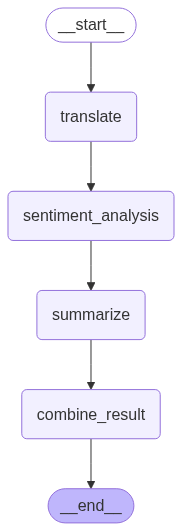

In [2]:
workflow